In [2]:
# Keras RNN을 이용하여 주식 시장 예측을 위한 간단한 일변량 모델 구축

import pandas_datareader as webreader

import math

import numpy as np

import pandas as pd

from datetime import date, timedelta, datetime

from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential

from keras.layers import LSTM, Dense, Dropout

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import RobustScaler, MinMaxScaler

import yfinance as yf

from matplotlib.axis import Axis

In [3]:
# API를 통해 yahoo finance.com에서 미국 S&P500 지수를 불러옵니다.
# ^GSPC' 는 S&P500의 symbol입니다.
# date_start를 통해 설정한 날짜부터 코드를 실행하는 날짜까지의 데이터를 불러옵니다.

today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

print(date_today)
print(date_start)

stockname = 'S&P500'
symbol = '^GSPC'

print(stockname)
print(symbol)

df = yf.download(tickers=['^GSPC'], start=date_start, end=date_today)

print(df.shape)
df.head(5)

2023-07-15
2010-01-01
S&P500
^GSPC
[*********************100%***********************]  1 of 1 completed
(3405, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


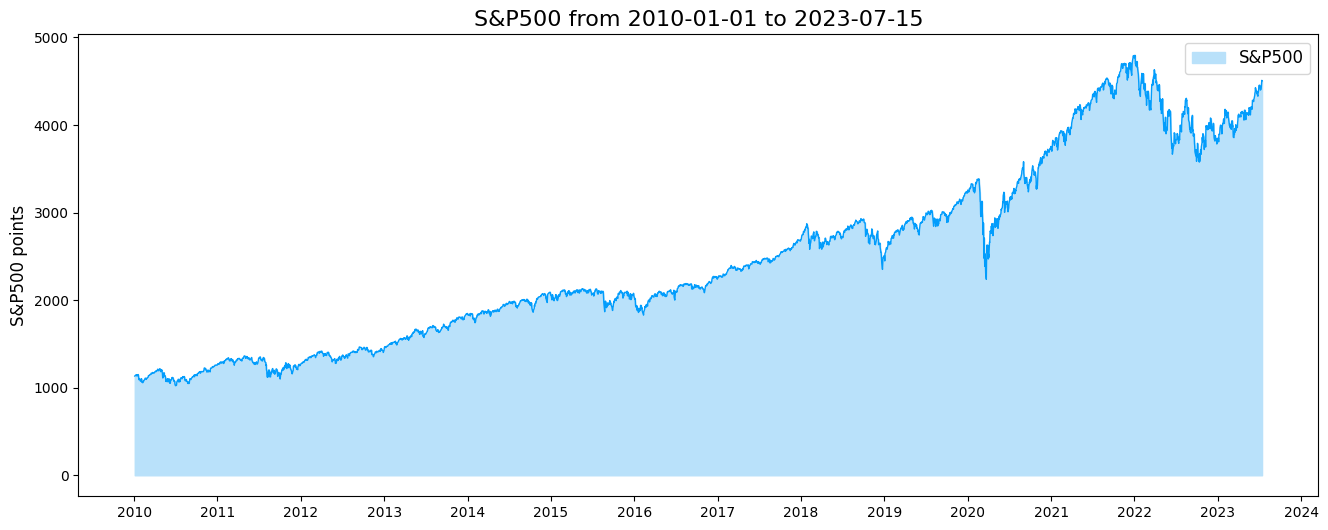

In [4]:
# 설정한 기간(2010년 ~ Code를 실행하는 시점)의 S&P500지수의 그래프를 작성합니다.

pd.plotting.register_matplotlib_converters()
years = mdates.YearLocator()
fig, ax1 = plt.subplots(figsize=(16,6))
Axis.set_major_locator(ax1.xaxis, years)
x = df.index
y = df['Close']
ax1.fill_between(x,0,y,color='#b9e1fa')
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from ' + date_start + ' to ' + date_today, fontsize=16)
plt.plot(y, color='#039dfc', label='S&P500', linewidth=1.0)
plt.ylabel('S&P500 points', fontsize=12)
plt.show()


In [5]:
# LSTM 훈련을 시작하기 전, 예측을 위한 훈련과 검증을 위해 Training data와 Test data로 분할합니다.
# 전체 자료 중 80%를 Training data 설정하고, Test data  20%로 설정하여 모델의 성능을 평가합니다.
# MinMaxScaler를 이용하여 데이터를 정규화를 수행해줍니다.

data = df.filter(['Close'])
npdataset = data.values

training_data_length = math.ceil(len(npdataset) *0.8)

mmscaler = MinMaxScaler(feature_range=(0,1))
scaled_data = mmscaler.fit_transform(npdataset)
scaled_data

array([[0.02925558],
       [0.03019094],
       [0.03035522],
       ...,
       [0.91404303],
       [0.92408014],
       [0.92285594]])

In [6]:
# 내일 시장 종가를 이전 100일의 시장 가격으로 기반으로 예측할 것입니다.
# Mini-batch라고 불리는 훈련 데이터(x_train)의 여러 조각을 만듭니다.
# 신경망은 모델을 훈련 할 때 미니배치를 하나씩 처리하고 각 미니배치에 대해 별도의 예측을 생성합니다.
# Input data의 shape는 신경망의 입력 계층(input layer)에 있는 뉴런의 수과 일치해야 합니다.
# 신경망은 예측 오류를 줄이기 위해 뉴런(가중치) 간의 연결 강도를 조정하여 학습합니다.

train_data = scaled_data[0:training_data_length,:]

x_train = []
y_train = []
trainingdatasize = len(train_data)
for i in range(100, trainingdatasize):
  x_train.append(train_data[i-100: i, 0])
  y_train.append(train_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape)
print(y_train.shape)

(2624, 100, 1)
(2624,)


In [7]:
# LSTM layer 수는 여러 번 반복 테스트하여 가장 적합한 parameter를 찾아야 합니다.
# 본 실습에서는 LSTM 2개층과 Dense 2개층, 총 4개의 layer에 대해 구성하였습니다.
# 뉴런의 수는 일반적으로 최소한 입력 데이터의 크기를 포함해야 합니다.
# 앞서 100일의 자료를 입력자료를 사용했기 때문에 뉴련의 수는 100으로 설정하였습니다.
# 마지막 layer에는 1개의 뉴런을 설정하였는데, 한 시점에 대한 단일 가격을 예측하는 것이기 때문입니다.

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 모델 학습
history = model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
164/164 [==============================] - 29s 155ms/step - loss: 0.0027 - accuracy: 3.8110e-04
Epoch 2/25
164/164 [==============================] - 23s 137ms/step - loss: 2.1386e-04 - accuracy: 3.8110e-04
Epoch 3/25
164/164 [==============================] - 22s 132ms/step - loss: 2.2191e-04 - accuracy: 3.8110e-04
Epoch 4/25
164/164 [==============================] - 22s 137ms/step - loss: 1.8348e-04 - accuracy: 3.8110e-04
Epoch 5/25
164/164 [==============================] - 23s 137ms/step - loss: 1.7252e-04 - accuracy: 3.8110e-04
Epoch 6/25
164/164 [==============================] - 22s 136ms/step - loss: 1.7174e-04 - accuracy: 3.8110e-04
Epoch 7/25
164/164 [==============================] - 22s 133ms/step - loss: 1.4277e-04 - accuracy: 3.8110e-04
Epoch 8/25
164/164 [==============================] - 23s 137ms/step - loss: 1.6269e-04 - accuracy: 3.8110e-04
Epoch 9/25
164/164 [==============================] - 23s 138ms/step - loss: 1.7010e-04 - accuracy: 3.8110e-04
Epoch

In [9]:
# test 자료 생성

test_data = scaled_data[training_data_length-100:, :]

x_test = []
y_test = npdataset[training_data_length:,:]

for i in range(100, len(test_data)):
  x_test.append(test_data[i-100:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [10]:
# 모델의 예측값을 생성합니다.
# 입력데이터가 0과 1사이의 범위로 조정되었기 때문에  원래 값으로 변경해줘야 합니다.

predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

22/22 [==============================] - 2s 56ms/step


In [11]:
# 예측오차(MAE)의 평균은 양수 또는 음수일 수 있으며, 양수일 경우 예측 값이 유효한 값이라는 것을 의미합니다.
# 평균제곱오차(RMSE)는 항상 양수입니다.

mae = mean_absolute_error(predictions, y_test)
print('MAE ' + str(round(mae,1)))

rmse = np.sqrt(np.mean(predictions-y_test)**2)
print('RMSE ' + str(round(rmse, 1)))

MAE 40.8
RMSE 12.9


In [12]:

display_start_date = "2018-01-01"

train = data[:training_data_length + 1]
valid = data[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"]- valid["Close"], True)



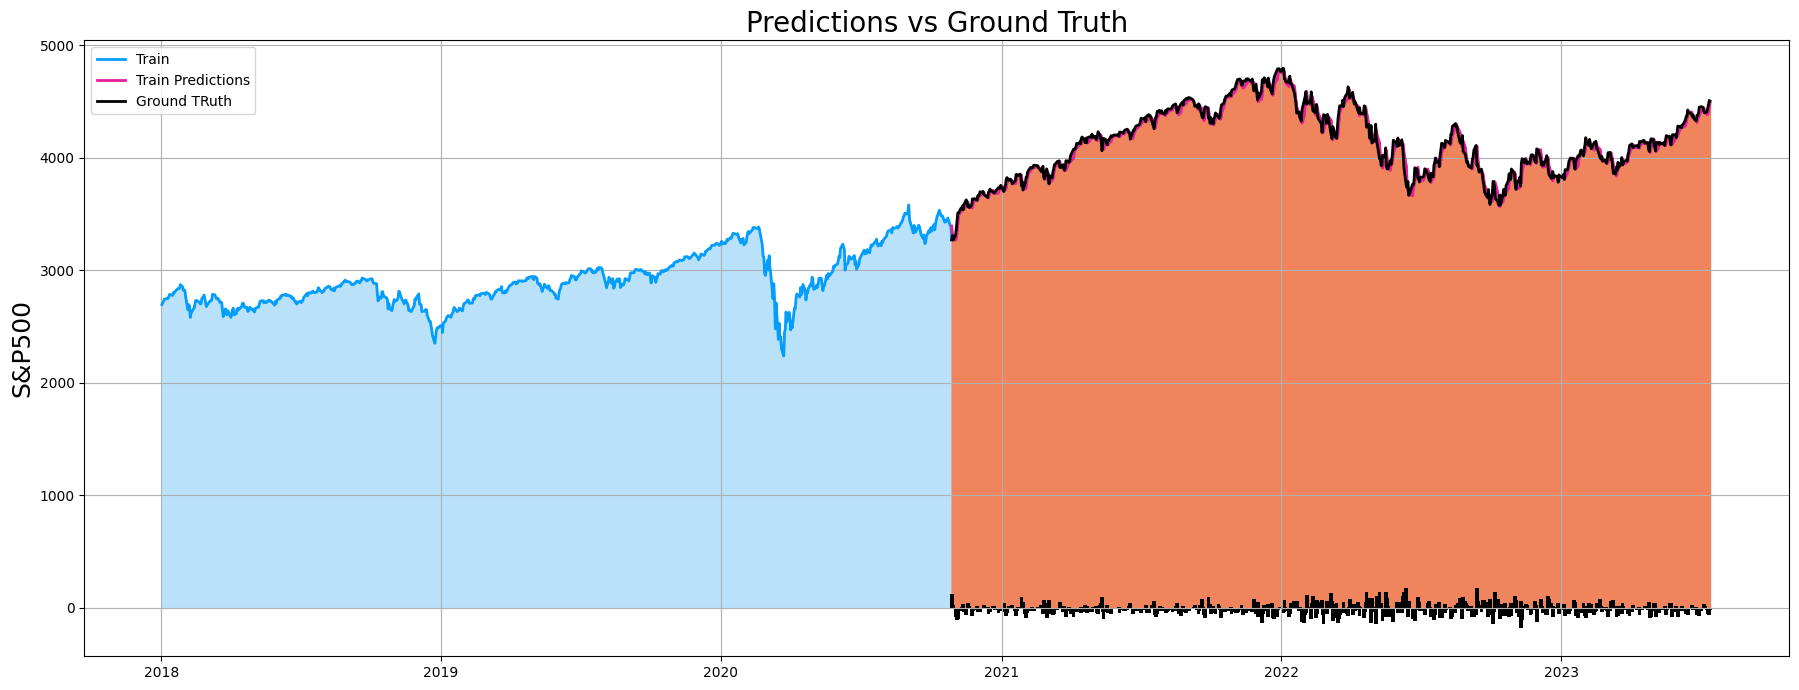

In [13]:
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(22,8), sharex=True)
xt = train.index; yt = train[["Close"]]
xv = valid.index; yv = valid[["Close", "Predictions"]]

plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname,fontsize=18)
plt.plot(yt, color='#039dfc', linewidth=2.0)
plt.plot(yv["Predictions"], color='#E91D9E', linewidth=2.0)
plt.plot(yv["Close"], color='black',linewidth=2.0)
plt.legend(["Train", "Train Predictions", "Ground TRuth"], loc='upper left')

ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Predictions"], color="#F0845C")
ax1.fill_between(xv, yv["Close"], yv["Predictions"], color="grey")

x = valid.index
y = valid["Difference"]
plt.bar(x,y,width=5, color="black")
plt.grid()
plt.show()




In [23]:
#  전체 데이터를 다시 불러와서 오늘 시점 기준 100일 이전의 데이터를 불러와 내일의 가격을 예측합니다.
#  내일 종가 예측은 3911.0으로 예측되었습니다.

# error ==> price_quote = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
price_quote = yf.download(tickers=['^GSPC'], start=date_start, end=date_today)
new_df = price_quote.filter(['Close'])

last_100_days = new_df[-100:].values
last_100_days_scaled = mmscaler.transform(new_df[-100:].values)

X_test = []
X_test.append(last_100_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

pred_price = model.predict(X_test)
pred_price = mmscaler.inverse_transform(pred_price)
data_tomorrow = date.today() + timedelta(days=1)

print('The price for' +  stockname  +  'at'  +  date_today  +  'was'  +  str(round(df.at[df.index.max(), 'Close'])))
print('The predicted' +  stockname  +  'price at date'  +  str(data_tomorrow)  +  'is'  +  str(round(pred_price[0,0], 0)))


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 35ms/step
The price forS&P500at2023-07-15was4505
The predictedS&P500price at date2023-07-16is4501.0
